# **Import**

The `pycadet` package together with all the dependencies can be installed using `pip`. If you encounter issues during the installation (`tensorflow` library can sometimes be tricky to install), try solving all the [requirements](https://github.com/tomasplsek/CADET) beforehand.

In [1]:
!pip install pycadet

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 1.9 MB/s eta 0:00:00m eta 0:00:010:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for pycadet: filename=pycadet-0.1.3-py3-none-any.whl size=6285037 sha256=7a5a22696c97d9e79c1fc628a331bb940a86c8dec09a8fd98e7e6d22bc52e0aa
  Stored in directory: /home/plsek/.cache/pip/wheels/08/1d/8d/c91c5dceae21741367f7a3e6375d8ad6a8739a8d8157860f2e
Successfully built pycadet


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.ndimage import center_of_mass

from pycadet import rebin, make_prediction, decompose, make_3D_cavity, CADET

2023-07-19 21:42:11.582284: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 21:42:12.445803: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


No GPUs detected. Using a CPU.



2023-07-19 21:42:13.648735: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-19 21:42:13.691387: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


# **Data**

The ***CADET*** pipeline inputs either raw *Chandra* images in units of counts (numbers of captured photons) or exposure-corrected images. When using exposure-corrected data, images are automatically normalized by the lowest pixel value (except for zeros) so that all pixels are higher than or equal to 1. For images with many point sources, we recommend filling the point sources with surrounding background level using Poisson statistics ([dmfilth](https://cxc.cfa.harvard.edu/ciao/ahelp/dmfilth.html) within [CIAO](https://cxc.harvard.edu/ciao/)).

Here we demonstrate the package using two exemplary images:

NGC4649.fits - image centred at the centre of the M60 galaxy, cropped to 512x512 pixels, and with filled point sources\
NGC4778.fits - exposure-corrected image of the original size of 2510x1916 pixels, includes point sources

In [3]:
!wget "https://github.com/tomasplsek/CADET/raw/main/example/NGC4649.fits" -O "NGC4649.fits"
!wget "https://github.com/tomasplsek/CADET/raw/main/example/NGC4778.fits" -O "NGC4778.fits"

--2023-07-19 21:42:13--  https://github.com/tomasplsek/CADET/raw/main/example/NGC4649.fits
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tomasplsek/CADET/main/example/NGC4649.fits [following]
--2023-07-19 21:42:14--  https://raw.githubusercontent.com/tomasplsek/CADET/main/example/NGC4649.fits
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2301120 (2,2M) [application/octet-stream]
Saving to: ‘NGC4649.fits’

NGC4649.fits        100%[===================>]   2,19M  2,72MB/s    in 0,8s    

2023-07-19 21:42:15 (2,72 MB/s) - ‘NGC4649.fits’ saved [2301120/2301120]

--2023-07-19 21:42:15--  https://g

(512, 512)

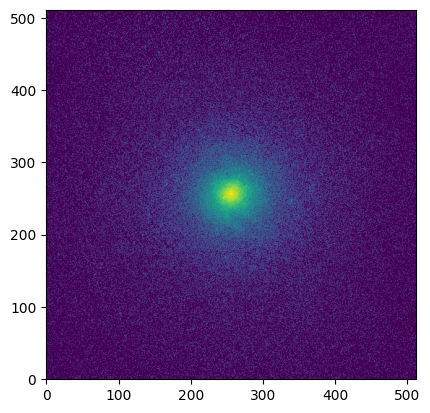

In [4]:
data = fits.getdata("NGC4649.fits")

plt.imshow(np.log10(data+1), origin="lower");

data.shape

(2510, 1916)

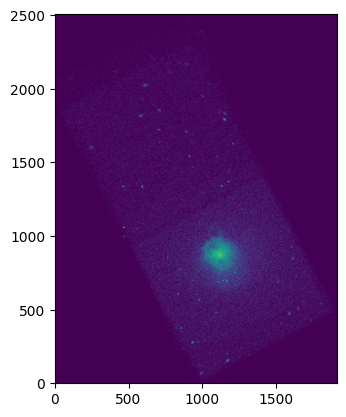

In [5]:
data = fits.getdata("NGC4778.fits")

plt.imshow(np.log10(data+1e-10), origin="lower");

data.shape

# **Rebin**

The ***CADET*** model can only input 128x128 images. Input images must therefore be cropped and binned to 128x128 pixels, which can be done using the `rebin` function. The crop size can be specified by the parameter `scale` (size = scale * 128 pixels). Images should either be centred at the galaxy center beforehand or their can be centred by specifying the `ra` and `dec` parameters. The re-binning is performed using *Astropy* and *Numpy* libraries and can only handle integer binsizes. For floating point number binning, we recommend using [dmregrid](https://cxc.cfa.harvard.edu/ciao/ahelp/dmregrid.html).

Arguments of the `rebin` function:\
`fname` - string; name of the input file\
`scale` - integer; specifies the crop size (size = scale * 128 pixels)\
`ra` - string or float; right ascension of the centre of the galaxy (optional)\
`dec` - string or float; declination of the centre of the galaxy (optional)\
`shift` - bool; if True, output shape is 130x130 instead of 128x128 (optional, default: `shift=False`)

In [6]:
from pycadet import rebin

In [7]:
data, wcs = rebin("NGC4649.fits", scale=2, ra="12:43:40.0057", dec="11:33:10.456")

(128, 128)

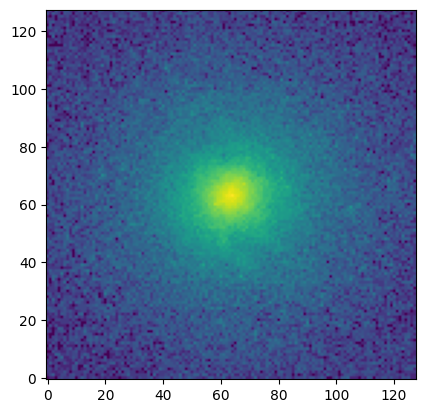

In [8]:
plt.imshow(np.log10(data+1), origin="lower");

data.shape

# **Make prediction**

The ***CADET*** model can be applied on the obtained binned image (`data`) by calling the `make_prediction` function with the binned image as an argument. On the output of this function, there is a pixel-wise prediction with values ranging from 0 to 1, which represents whether the corresponding pixel belongs to a cavity or not.

Arguments of the `make_prediction` function:\
`data` - numpy array; input image of shape (128, 128) or (130, 130) if `shift=True`\
`shift` - bool; if True, the prediction is averaged by shifting the image by +/- 1 pixel (optional, default: `shift=False`)

In [9]:
from pycadet import make_prediction

In [10]:
%time pred = make_prediction(data)

CPU times: user 17 s, sys: 252 ms, total: 17.3 s
Wall time: 4.42 s


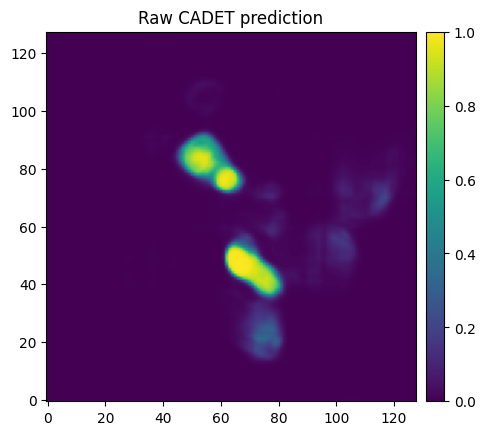

In [11]:
from matplotlib.colors import Normalize

plt.title("Raw CADET prediction")
plt.imshow(pred, origin="lower", norm=Normalize(0,1))
plt.colorbar(fraction=0.046, pad=0.02);

## **Shifting**

To suppress uncertainties connected with improper image centering as well as with activating slightly different neurons in the ***CADET*** model, the ***CADET*** pipeline includes the possibility to shift the centre of the input image by +/- 1 pixel in both X and Y directions. If `shift=True`, the final predictions is thus averaged from 9 differently shifted input images (the execution time is approximatelly 8 times longer).

When using the shifting option, the `make_prediction` function inputs 130x130 images. To obtain the binned image of this shape, the `shift=True` option also needs to be set in the `rebin` function. The shape of the resulting pixel-wise prediction is however still 128x128 pixels.

In [12]:
data, wcs = rebin("NGC4649.fits", scale=2, shift=True, ra="12:43:40.0057", dec="11:33:10.456")

data.shape

(130, 130)

In [13]:
%time pred = make_prediction(data, shift=True)

pred.shape

2023-07-19 21:42:35.699024: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 199229440 exceeds 10% of free system memory.
2023-07-19 21:42:38.040198: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 199229440 exceeds 10% of free system memory.
2023-07-19 21:42:42.502585: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 199229440 exceeds 10% of free system memory.
2023-07-19 21:42:46.931408: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 199229440 exceeds 10% of free system memory.


CPU times: user 3min 9s, sys: 3.42 s, total: 3min 13s
Wall time: 33.5 s


(128, 128)

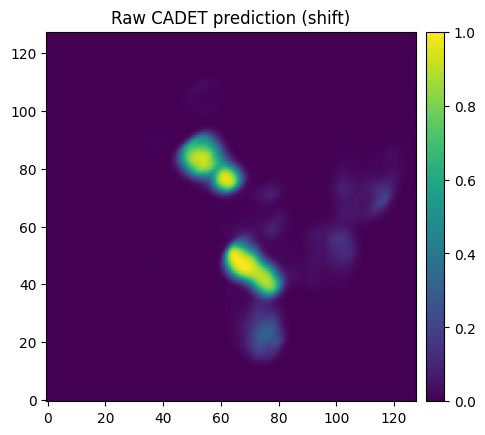

In [14]:
plt.title("Raw CADET prediction (shift)")
plt.imshow(pred, origin="lower", norm=Normalize(0,1))
plt.colorbar(fraction=0.046, pad=0.02);

# **Decompose**

To allow manipulation with individual X-ray cavities, the pixel-wise prediction obtained by the `make_prediction` function can be further decomposed into individual cavities using the DBSCAN algorithm (`decompose` function). However, prior to decomposition, the raw pixel-wise prediction must be thresholded. In order to simultaneously calibrate the volume error and the false positive rate, we introduced two discrimination thresholds (for more info see [Plšek et al. 2023](https://arxiv.org/abs/2304.05457)) with default values of 0.4 and 0.6, respectively. However, both discrimination thresholds are changeable and can be set to an arbitrary value between 0 and 1.

Arguments of the `decompose` function:\
`pred` - numpy array; pixel-wise prediction of shape (128, 128)\
`th1` - float; volume calibrating discrimination threshold (optional, default: `th1=0.4`)\
`th2` - float; FP rate calibrating discrimination threshold (optional, default: `th2=0.6`)\
`amin` - integer; minimal cavity area in units of pixels (optional, default: `amin=10`)

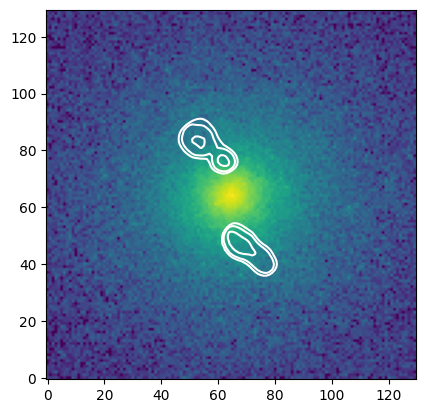

In [15]:
plt.imshow(np.log10(data+1), origin="lower");

plt.contour(pred, levels=[0.4, 0.6, 0.9], colors="white");

In [16]:
from pycadet import decompose

In [17]:
cavities = decompose(pred, th1=0.4, th2=0.6)

len(cavities), cavities[0].shape

(2, (128, 128))

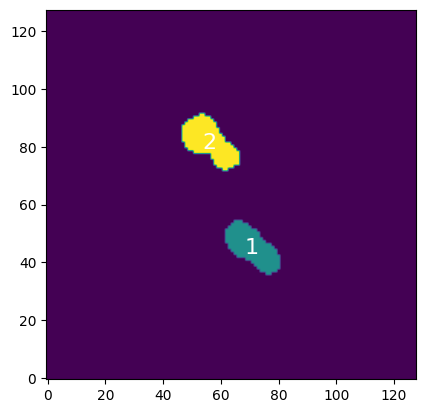

In [18]:
cavs = np.zeros((128,128))
for i, cav in enumerate(cavities):
    cavs += (i+1) * np.where(cav > 0, 1, 0)

plt.imshow(cavs, origin="lower")
for i, cav in enumerate(cavities):
    plt.text(*center_of_mass(cav)[::-1], i+1, fontsize=16, ha="center", va="center", c="w")

# **Make 3D cavity**

The decomposed cavities can be turned into a 3D cavity model using a `make_3D_cavity` function. The 3D models of X-ray cavities are created under the assumption of rotational symmetry along the direction from the galactic centre towards the centre of the cavity. The depth of the cavity at each point along this direction is then assumed to be equal to its width. The output of the `make_3D_cavity` function is a 3D matrix of shape (128, 128, 128) and the resulting 3D cavity model can be saved in the `.npy` format and can be used for further calculations (e.g. cavity energy estimation).

Arguments of the `make_3D_cavity` function:\
`cavity` - numpy array, individual cavity matrices

In [19]:
from pycadet import make_3D_cavity

In [20]:
cube = make_3D_cavity(cavities[0])
cube += make_3D_cavity(cavities[1])

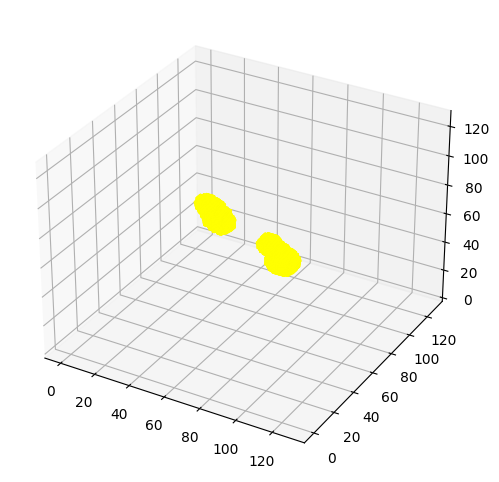

In [21]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.voxels(cube, edgecolor="yellow", facecolors="yellow", alpha=0.5);

# **CADET pipeline**

The `pycadet` package also includes the full CADET pipeline. The pipeline takes an input image (`fname`), crops it on multiple scales specified by the `scales` parameter around central coordinates defined by the `ra` and `dec` parameters (uses centre of the image if not specified), and bins them to the desired shape (depending on the `shift` parameter). It then applies the CADET model to images of individual scales and decomposes the predictions into individual cavities.

The pipeline also creates a folder with the same name as the FITS file, and saves the corresponding pixel-wise as well as decomposed cavity predictions in FITS format, while also properly preserving the WCS coordinates. The pipeline also generates 3D representations of the cavities and saves them in the `.npy` format in the *cubes* folder. The pipeline also creates a PNG file showing the pixel-wise predictions for each scale as contours superimposed on the original images.

Arguments of the `CADET` function:
`fname` - string; name of the input file\
`scales` - list of integers; specifies the crop sizes (size = scale * 128 pixels)\
`ra` - string or float; right ascension of the centre of the galaxy (optional)\
`dec` - string or float; declination of the centre of the galaxy (optional)\
`shift` - bool; if True, output shape is 130x130 instead of 128x128 (optional, default: `shift=False`)\
`th1` - float; volume calibrating discrimination threshold (optional, default: `th1=0.4`)\
`th2` - float; FP rate calibrating discrimination threshold (optional, default: `th2=0.6`)

In [22]:
from pycadet import CADET

---- Running CADET ----
Reading file: NGC4649.fits

Original image size: 512x512 pixels
Selected scales: [1, 2, 3, 4]

RA & DEC not specified.
Using the center of the image:
RA:  12:43:39.98 hours
DEC: 11:33:09.98 degrees

Creating directories:
NGC4649/
  ├ predicitons/
  ├ decomposed/
  └ cubes/

Processing images with CADET:
128x128 pixels:    detected 4 cavities
256x256 pixels:    detected 2 cavities
384x384 pixels:    WARNING:tensorflow:5 out of the last 6 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f4100646290> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensor

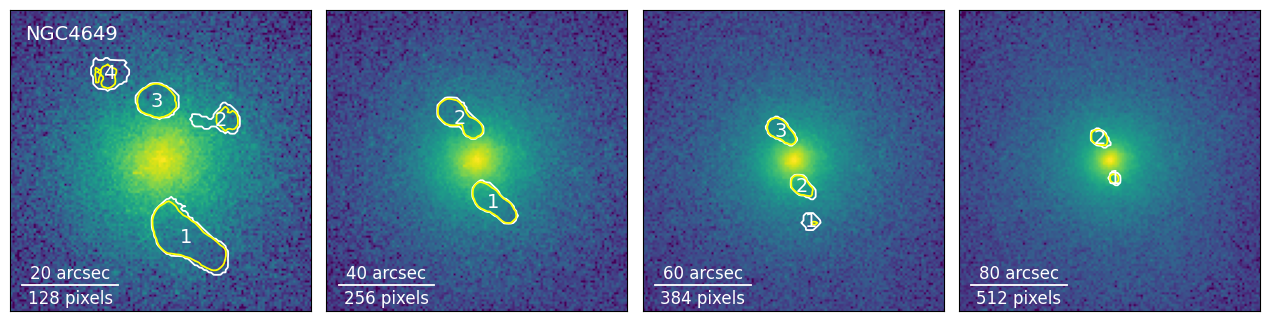

In [23]:
CADET("NGC4649.fits", scales=[1,2,3,4], th1=0.4, th2=0.6)

---- Running CADET ----
Reading file: NGC4778.fits

Original image size: 2510x1916 pixels
Selected scales: [1, 2, 3, 4, 5]
RA:  12:53:05.6621 hours
DEC: -9:12:14.883 degrees

Creating directories:
NGC4778/
  ├ predicitons/
  ├ decomposed/
  └ cubes/

Processing images with CADET:
128x128 pixels:    detected 2 cavities
256x256 pixels:    detected 2 cavities
384x384 pixels:    detected 3 cavities
512x512 pixels:    detected 3 cavities
640x640 pixels:    detected 3 cavities


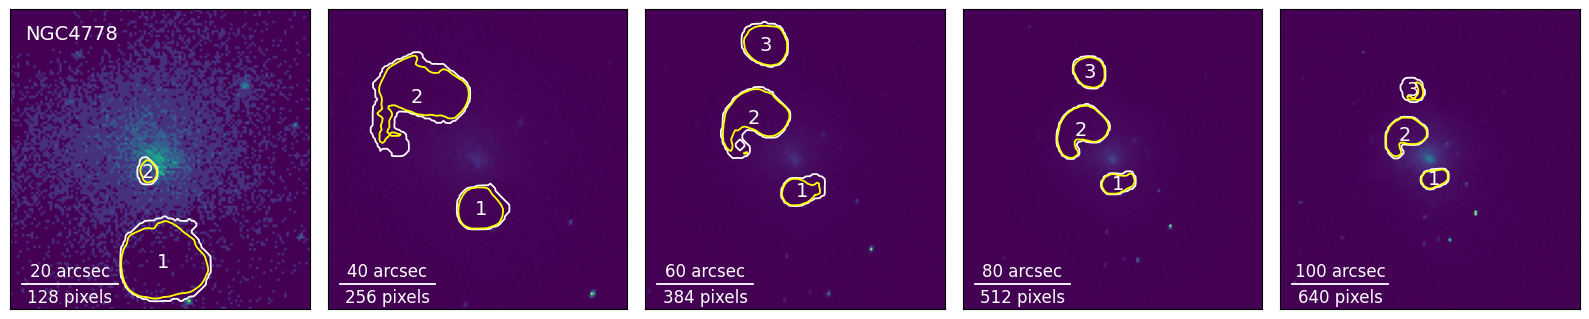

In [24]:
CADET("NGC4778.fits", scales=[1,2,3,4,5], ra="12:53:05.6621", dec="-9:12:14.883", th1=0.4, th2=0.7)